# Executive Summary

The project started by scraping r/travel and r/awardtravel for data. The process of extracting from reddit is fairly simple: 
 *  A basic request set up to access the API
I managed to scrape about 15,000 posts in total.

I made an app on reddit to register and get the keys and password using praw.To extract the title and selftext,I used PushshiftAPI. Once I extracted the titlw and selftext (as body). Then I began the process of cleaning up the data. The cleaning process was fairly simple, as it mostly consisted of dropping null values, stripping all text that was not composed of letters, removing emojis,replacing the [removed] and [deleted] values with nothing. The last major cleaning step I did was to concatenate together the title and body for each post,because if there was no body the title became the body. I then saved the dataframes to a csv file so I could model cleaned data.

So,during preprocessing I remove the urls and links too.Then I combined the dataframes for both the subreddits,as it would be easier to modelthat ways. And then I looked at what are the common words that occurred most frequently and added those words to the list of stop words. The last preprocessing step I took was to lemmatize the text; lemmatizing  reduces every word to its dictionary value and is a bit gentle that stemming.

I ran each model was twice: once with count vectorization and once with TFIDF vectorization
Every model was optimized with grid-searching(to tune the hyperparameters in a better way)
Models that I considered were:
1. Logistic Regression
2. Multinomial Naive Bayes
3. Random Forest
Once I had my best parameters and best estimator I made a confusion matrix(the confusion gives the clearest visualization of how the model treats each class in the data).I also generated an ROC-AUC curve.

Then I also wanted to test my model on an unseen data.So I also pulled some extra data and from reddit API,stored it in the test.csv and tested my model on that.It performed very good on that.

In [7]:
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
import nltk
# Import Tokenizer
from nltk.tokenize import RegexpTokenizer
# Import stopwords.
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix


In [8]:
#loading the travel file  and storing it in the travel data frame
travel = pd.read_csv(".datasets/df_travel.csv")

In [9]:
#checking the first five rows of the dataframe
travel.head()

,Unnamed: 0,status,target
0,0,US Visa choices?Im planning a holiday for my g...,1
1,1,Moving out of state?,1
2,2,I have a history of traveler's sickness when v...,1
3,3,Asking for tips on visiting Louvre for first t...,1
4,4,Any ideas for a nice weekend trip with my girl...,1


In [10]:
#dropping the unnamed:0 column
travel.drop(columns = 'Unnamed: 0',inplace =True)

In [11]:
travel.shape

(7000, 2)

In [12]:
#checking for null values
travel[travel['status'].isnull()]

,status,target
426,NaN,1
1359,NaN,1
1810,NaN,1
1847,NaN,1
4010,NaN,1
5091,NaN,1


In [13]:
#dropping the nullvalues
travel.dropna(inplace=True)

In [14]:
#checking if it worked
travel.isnull().sum()

status    0
target    0
dtype: int64

In [15]:
#loading the award mile file  and storing it in the awards data frame
awards = pd.read_csv(".datasets/df_awards.csv")
awards.drop(columns = 'Unnamed: 0',inplace =True)

In [16]:
awards.head()

,status,target
0,Maximizing my travel plans for 2020Hi! Not sur...,0
1,does cancelling a southwest ticket make a new ...,0
2,Suggestions on best way to get open jaw ticket...,0
3,"Skiplagging AA AwardHi All, may not be flying ...",0
4,"Is there a sub thread for expiring upgrades, l...",0


In [17]:
awards.isnull().sum()

status    0
target    0
dtype: int64

In [18]:
awards.shape

(8000, 2)

In [19]:
travel.shape

(6994, 2)

In [20]:
frames =[travel,awards]

In [21]:
#concatenating the two dataframes in one final dataframe to be used for modelling
final = pd.concat(frames,axis=0,ignore_index=True)

In [22]:
final.shape

(14994, 2)

In [23]:
# Get the number of status based on the dataframe size.
total_status = final.shape[0]
print(f'There are {total_status} statuses.')

There are 14994 statuses.


In [24]:
# Function to convert a raw status to a string of words
# The input is a single status, and 
# the output is a single string (a preprocessed subreddit status)   
    
def status_to_words(raw_status): 
    
    # 1. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", raw_status)
    
    # 2. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 3. In Python, searching a "set" is much faster than searching
    # a list, so convert the stop words to a "set".
    stops = set(stopwords.words('english'))
    
    # 4. Remove stop words.
    meaningful_words = [w for w in words if w not in stops]
    
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [25]:
# Initialize an empty list to hold the clean reviews.
clean_status = []
# clean_test_reviews = []

print("Cleaning and parsing the  status ")

j = 0
for status in final['status']:
    # Convert status to words, then append to clean_status.
    clean_status.append(status_to_words(status))
    
    # If the index is divisible by 1000, print a message
    if (j + 1) % 1000 == 0:
        print(f'status {j + 1} of {total_status}.')
    
    j += 1

# # Let's do the same for our testing set.

# print("Cleaning and parsing the testing set movie reviews...")

# for test_review in X_test['review']:
#     # Convert review to words, then append to clean_train_reviews.
#     clean_test_reviews.append(review_to_words(test_review))
    
#     # If the index is divisible by 1000, print a message
#     if (j + 1) % 1000 == 0:
#         print(f'Review {j + 1} of {total_reviews}.')
        
#     j += 1

Cleaning and parsing the  status 
status 1000 of 14994.
status 2000 of 14994.
status 3000 of 14994.
status 4000 of 14994.
status 5000 of 14994.
status 6000 of 14994.
status 7000 of 14994.
status 8000 of 14994.
status 9000 of 14994.
status 10000 of 14994.
status 11000 of 14994.
status 12000 of 14994.
status 13000 of 14994.
status 14000 of 14994.


In [26]:
#assigning the cklean status to the status column
final['status']= clean_status

In [27]:
final.head()

,status,target
0,us visa choices im planning holiday gap year s...,1
1,moving state,1
2,history traveler sickness visiting tropical fo...,1
3,asking tips visiting louvre first time,1
4,ideas nice weekend trip girlfriend within driv...,1


In [28]:

custom_stop = list(ENGLISH_STOP_WORDS)

cv = CountVectorizer(stop_words=custom_stop, min_df=6)
word_frame = pd.DataFrame(cv.fit_transform(final['status']).todense(), \
                          columns=cv.get_feature_names())
word_frame.head()

,aa,aaa,aadvantage,aai,aanytime,aas,ab,ability,able,abq,...,zilara,zimbabwe,zion,zip,ziva,zone,zoo,zrh,zur,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
trav = word_frame.loc[final['target'] == 1,:].copy()
awar = word_frame.loc[final['target']== 0, :].copy()


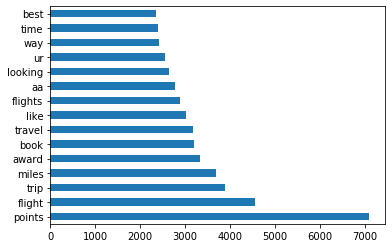

In [30]:

#plotting the bar graph of all the common words
word_frame.sum().sort_values(ascending=False).head(15).plot.barh();


In [31]:
common_words = word_frame.sum().sort_values(ascending=False).head(20).index

In [32]:
common_words

Index(['points', 'flight', 'trip', 'miles', 'award', 'book', 'travel', 'like',
       'flights', 'aa', 'looking', 'ur', 'way', 'time', 'best', 'use',
       'business', 'united', 'class', 'booking'],
      dtype='object')

In [33]:
stop1 = ['points', 'flight', 'trip', 'miles', 'award', 'book', 'travel', 'like',
       'flights', 'aa', 'looking', 'ur', 'way', 'time', 'best', 'use',
       'business', 'united', 'class', 'booking']

In [34]:
#concatenating the stop list with my custom stop word list (stop1)
stop =custom_stop + stop1

In [35]:
import wordcloud

In [38]:
def wordclouder(target, colormap_in='inferno'):

    wc = wordcloud.WordCloud(max_words=100, width=600,height=300,
                            colormap=colormap_in)

    raw_text = final.loc[final['target'] == target, 'status'].str.cat()

    cloud = wc.generate(raw_text)

    return cloud.to_image()


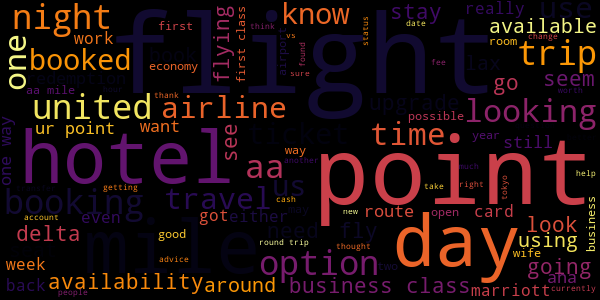

In [41]:
wordclouder(0)

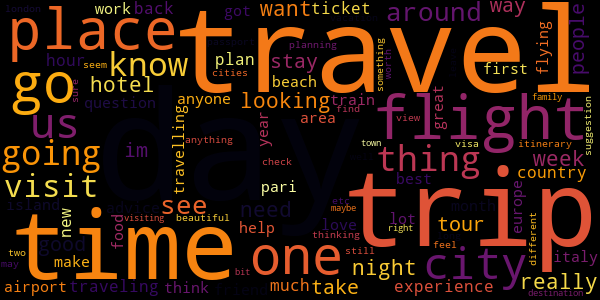

In [39]:
wordclouder(1)

In [43]:
type(stop)

list

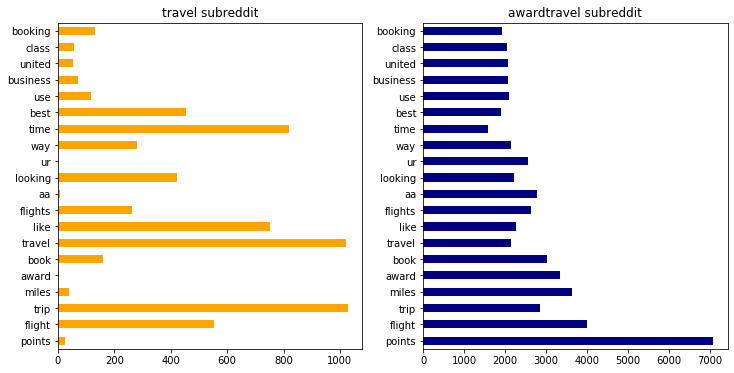

In [44]:
#plotting the frequency of common words in both the subreddits
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6));

trav[common_words].sum().plot.\
barh(ax=ax1, title='travel subreddit', color='Orange');
awar[common_words].sum().plot.\
barh(ax=ax2, title='awardtravel subreddit', color='Navy');


In [45]:
#function to lemmatize the text
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(token) for token in text.split()]
    return " ".join(text)

In [46]:
#lemmatizing the status
final['status'] = final['status'].apply(lemmatize)

In [47]:
final.head()

,status,target
0,u visa choice im planning holiday gap year sta...,1
1,moving state,1
2,history traveler sickness visiting tropical fo...,1
3,asking tip visiting louvre first time,1
4,idea nice weekend trip girlfriend within drivi...,1


In [48]:
#defining the X (feature)and y (target)variable for modelling
X = final['status']
y = final['target']

In [49]:
X.shape[0]

14994

In [50]:
y.shape[0]

14994

In [51]:
#checking the accuracy of the baseline model
y.value_counts(normalize = True)

0    0.533547
1    0.466453
Name: target, dtype: float64

In [139]:
# X_train.shape

In [140]:
# y_train.shape

In [52]:
#function for gridsearch
def grid_search(X,y):
    
    # Split the data into the training and testing sets.
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)
    #pipeline for random forest with cvec
    pipeline1 = Pipeline([
    ('cvec', CountVectorizer()),   
    ('rfc', RandomForestClassifier()),
    
    ])
    
    #pipeline for random forest with tvec
    pipeline2 = Pipeline([
    ('tvec', TfidfVectorizer()),   
    ('rfc', RandomForestClassifier()),
    
    ])
    
    #pipeline for LogisticRegression with cvec
    pipeline3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
    ])
    
    #pipeline for LogisticRegression with cvec
    pipeline4 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
    ])
     
    #pipeline for Multinomial Naive Bayes with cvec
    pipeline5 = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB()),
    ])
    
   #pipeline for Multinomial Naive Bayes with tvec
    pipeline6 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB()),
    ])
    
# #     #pipeline for support vector machine
#     pipeline4 = Pipeline([
#     ('tvec', TfidfVectorizer()),
#     ('clf', SVC()),
#     ])

#     
    #parameters for random forest with cvec
    grid_param1 = {
    'cvec__max_features':[3000],
    'cvec__stop_words': [stop],
    'cvec__ngram_range': [(1, 1),(1,2)],
    'rfc__n_estimators': [10, 30],
    'rfc__criterion': ['gini'],
    'rfc__max_depth': [3,4]
    }
     #parameters for random forest with tvec
    grid_param2 = {
    'tvec__max_features':[3000],
    'tvec__stop_words': [stop],
    'tvec__ngram_range': [(1, 1),(1,2)],
    'rfc__n_estimators': [10, 30],
    'rfc__criterion': ['gini'],
    'rfc__max_depth': [3,4]
    }
    
      
    #parameters for log regression with cvec
    grid_param3 = {
    'cvec__max_features':[5000,3000],
    'cvec__ngram_range':[(1,1),(1,2),(1,3)],
    'cvec__stop_words':[stop]
     }
       
   #parameters for log regression with tvec
    grid_param4 = {
    'tvec__max_features':[3000],
    'tvec__stop_words': [stop],
    'tvec__ngram_range': [(1, 1),(1,2),(1,3)]
    }
    
# #     #parameters for SVM
#     grid_param4 = {
#     'tvec__max_features':[1000],
#     'tvec__stop_words': [ None,stop],
#     'tvec__ngram_range': [(1, 1),(1,2)],
#     'clf__C': [0.01, 0.1, 1.0],
#     'clf__kernel': ['rbf', 'poly'],
#     'clf__gamma': [0.01, 0.1, 1.0],

#     }
    
   #parameters for Multinomial Naive Bayes cvec
    grid_param5 = {
    'cvec__max_features':[1000,3000], 
    'cvec__ngram_range':[(1,1),(1,2),(1,3)],
    'cvec__stop_words':[stop],
    'mnb__alpha': [0.01, 0.1, 1.0]
    }

    #parameters for Multinomial Naive Bayes tvec
    grid_param6 = {
    'tvec__max_features':[1000,3000], 
    'tvec__ngram_range':[(1,1),(1,2),(1,3)],
    'tvec__stop_words':[stop],
    'mnb__alpha': [0.01, 0.1, 1.0]
    }
    
    
    parameters = [ grid_param1,grid_param2,grid_param3,grid_param4,grid_param5,grid_param6]
    pipes = [ pipeline1,pipeline2,pipeline3,pipeline4,pipeline5,pipeline6]

    print("starting Gridsearch")
    for i in range(len(parameters)):
        if i==0 :
            print("for random forest and cvec")
        
        elif i==1:
            print("for random forest and cvec")
            
        elif i==2:
            print("for logistic regression and cvec")
            
        elif i==3:
            print("for logistic regression and tvec")
            
        elif i==4:
            print("for multinomialnb and cvec")
        else:
            print("for multinomialnb and tvec")
            
        gs = GridSearchCV(pipes[i], parameters[i],cv=3, verbose=2, n_jobs=-1)
        
        gs = gs.fit(X_train, y_train)
        print(f"finished Gridsearch{i+1}")
        print(f'training score{gs.score(X_train,y_train)}')
        print(f'training score{gs.score(X_test,y_test)}')
#         print(gs.best_params_)

In [ ]:
#calling grid_search
grid_search(X,y)

In [54]:
pipe_paramstv = {
    'tvec__max_features':[3000],
    'tvec__stop_words': [stop,None],
    'tvec__ngram_range': [(1, 1),(1,2),(1,3)]
}

In [55]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [56]:
X_train.shape

(11245,)

In [57]:
tvec = TfidfVectorizer()
X_train = tvec.fit_transform(X_train)

X_test =tvec.transform(X_test)

In [58]:
# Instantiate logistic regression.
lr = LogisticRegression()

# Fit logistic regression.
lr.fit(X_train, y_train)

# Evaluate logistic regression.
print(f'Training Score: {lr.score(X_train, y_train)}')
print(f'Testing Score: {lr.score(X_test, y_test)}')

Training Score: 0.9575811471765229
Testing Score: 0.9367831421712457


/Users/payalchodha/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [59]:
#calculating the predicted values for the best model
pred = lr.predict(X_test)

In [60]:
#making the confusion matrix
confusion_matrix(y_test, # True values.
                 pred)  # Predicted values.

array([[1824,  176],
       [  61, 1688]])

In [61]:
#calculating the misclassified indicesa
misclassified = np.where(y_test != pred)

In [63]:
misclassified

(array([  12,   16,   24,   45,   46,   72,   94,  150,  169,  198,  259,
         263,  292,  298,  332,  347,  370,  391,  413,  419,  423,  435,
         467,  480,  488,  494,  498,  502,  512,  542,  547,  583,  620,
         622,  628,  634,  652,  675,  679,  697,  718,  728,  751,  775,
         782,  785,  789,  796,  798,  799,  819,  825,  839,  844,  856,
         880,  893,  941,  963,  965,  974,  989, 1033, 1051, 1069, 1081,
        1091, 1096, 1128, 1140, 1142, 1147, 1190, 1191, 1198, 1208, 1215,
        1232, 1263, 1280, 1297, 1348, 1371, 1383, 1428, 1438, 1455, 1457,
        1463, 1469, 1472, 1481, 1502, 1525, 1563, 1613, 1624, 1631, 1637,
        1665, 1689, 1706, 1712, 1722, 1723, 1735, 1738, 1754, 1777, 1781,
        1872, 1880, 1913, 1914, 1922, 1932, 1953, 1964, 1979, 1980, 1985,
        1987, 1996, 2008, 2033, 2037, 2058, 2063, 2084, 2094, 2120, 2134,
        2168, 2176, 2181, 2205, 2220, 2236, 2253, 2257, 2267, 2286, 2296,
        2307, 2339, 2350, 2354, 2358, 

In [64]:
#calculating the predicted probabilities 
pred_proba = [i[1] for i in lr.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})



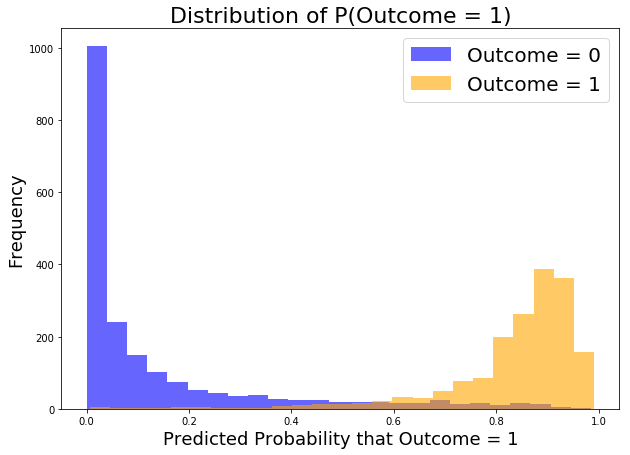

In [204]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'], #actually alive
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'], #actually dead
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

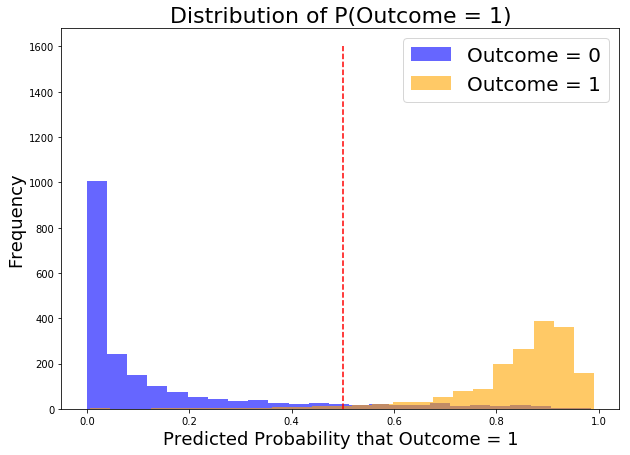

In [205]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 1600,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

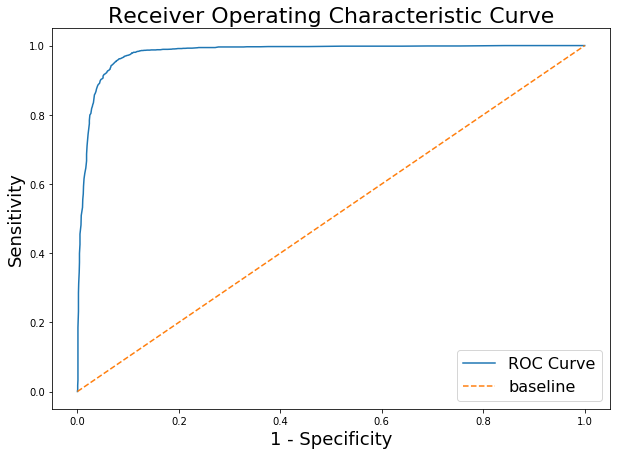

In [65]:
#creating ROC curve for the best model i.e Tvec and LogisticRegression
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [161]:
#checking the model on the unseen data(fetched  800 new status values for the test file  )
Test = pd.read_csv(".datasets/test_file.csv")

In [162]:
Test.isnull().sum()

Unnamed: 0    0
status        3
target        0
dtype: int64

In [163]:
Test.dropna(inplace=True)

In [167]:
test_val=tvec.transform(Test['status'])

In [168]:
preds = lr.predict(test_val)

In [176]:
confusion_matrix(Test['target'], # True values.
                 preds)  # Predicted values.

array([[266,  34],
       [  5, 492]])

In [179]:

misclassified = np.where(Test['target'] != preds)

In [178]:
misclassified

(array([ 34, 125, 151, 247, 494, 504, 513, 529, 534, 541, 565, 568, 575,
        579, 593, 598, 602, 605, 618, 624, 630, 645, 652, 669, 691, 694,
        696, 724, 725, 733, 746, 747, 754, 773, 775, 781, 783, 795, 796]),)

# Conclusions and Recommendations:

* Logistic regression performs good with cvec  and has even better accuracy score for Tfidf, and it also doesn’t show high variance.So I recommend employing Logistic Regression with TfidfVectorizer  moving forward!

* My model was able to predict with good accuracy the classification of a certain post.That's why it can be leveraged by Reddit to suggest subreddits to a user while writing a post.

* Also it can unlock ways to better target the awardtravel customers for the credit card offers etc.
 
 
 
